# Klasifikasi Gambar

In [8]:
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Konfigurasi model 
img_height, img_width = 255, 255
batch_size = 32

## Image Augmentation

In [32]:
class ImageAugmentor:
    def __init__(self):
        pass
    
    def horizontal_augment(self, image):
        """Flip the image horizontally."""
        return cv2.flip(image, 1)
    
    def scaling_augment(self, image, scale_percent=70):
        """Scale the image by a given percentage."""
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        dim = (width, height)
        return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    
    def translation_augment(self, image, tx=50, ty=50):
        """Translate the image by tx and ty pixels."""
        rows, cols, _ = image.shape
        M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image, M_translation, (cols, rows))
    
    def rotation_augment(self, image, angle=45):
        """Rotate the image by a given angle."""
        rows, cols, _ = image.shape
        M_rotation = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        return cv2.warpAffine(image, M_rotation, (cols, rows))
    
    def blur_augment(self, image, ksize=(5, 5)):
        """Apply Gaussian blur to the image."""
        return cv2.GaussianBlur(image, ksize, 0)
    
    def apply_all(self, image):
        """Apply all augmentations to the image and return a dictionary of results."""
        return {
            "horizontal": self.horizontal_augment(image),
            "scaled": self.scaling_augment(image),
            "translated": self.translation_augment(image),
            "rotated": self.rotation_augment(image),
            "blurred": self.blur_augment(image)
        }

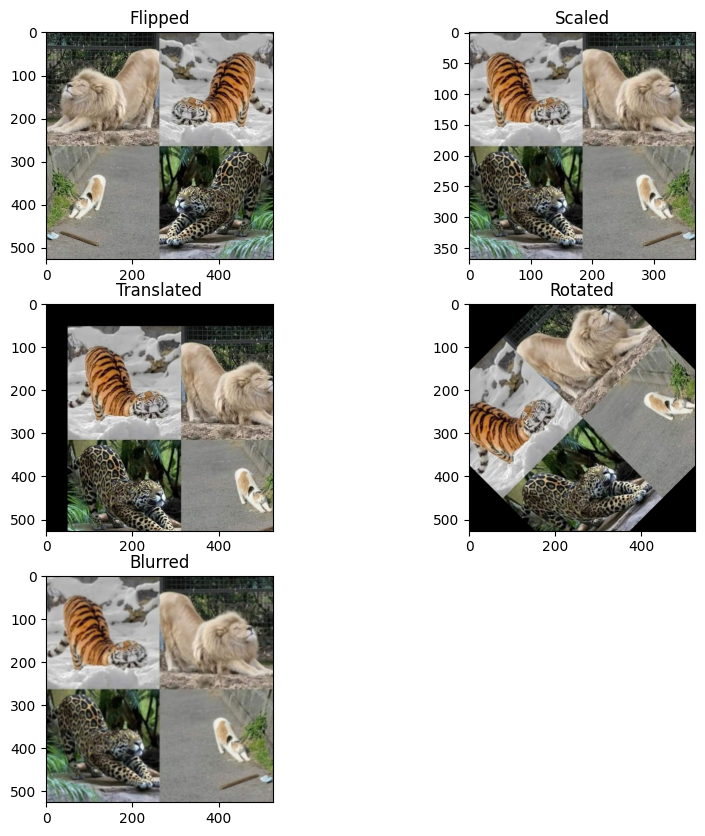

In [33]:

# Example usage
image_path = 'kucing.jpg'
image = cv2.imread(image_path)
imgAug = ImageAugmentor()
augmented_img = imgAug.apply_all(image)

# Display the augmented images
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(cv2.cvtColor(augmented_img["horizontal"], cv2.COLOR_BGR2RGB))
plt.title('Flipped')
plt.subplot(3, 2, 2)
plt.imshow(cv2.cvtColor(augmented_img["scaled"], cv2.COLOR_BGR2RGB))
plt.title('Scaled')
plt.subplot(3, 2, 3)
plt.imshow(cv2.cvtColor(augmented_img["translated"], cv2.COLOR_BGR2RGB))
plt.title('Translated')
plt.subplot(3, 2, 4)
plt.imshow(cv2.cvtColor(augmented_img["rotated"], cv2.COLOR_BGR2RGB))
plt.title('Rotated')
plt.subplot(3, 2, 5)
plt.imshow(cv2.cvtColor(augmented_img["blurred"], cv2.COLOR_BGR2RGB))
plt.title('Blurred')
plt.show()

## Define the Model

In [34]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (2,2), activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(3, activation="softmax"))

In [35]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [37]:
# Define Callback
from keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") >= 0.95:
            print("Reached 95% accuracy. Stopping training...")
            self.model_stop_training = True